## Performance measurements of a specific ppo agent
### ( ppo is not completely implemented yet) 

![Cartpole environment](https://nav74neet.github.io/media/blog/openaigym/openaigym.jpg)

### Includes:
    - Tensorboard:
        - Loss
        - Av return 
        - Av Episode length
        - Gradient norms 
        - Variable norms
        
    - Final Policy evaluation
    - Best Policy evaluation
    - Videos of both policies

In [11]:
# Set the GPU for training
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [19]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'modules/')

In [20]:
from modules.train_eval import *
from modules.transformers_encoders import * 
from modules.utils import *

In [21]:
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
from tf_agents.networks import network
from tf_agents.environments import tf_environment
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gym
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import policy_saver
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories.trajectory import *
from tf_agents.utils import common 
from tf_agents.environments.tf_wrappers import TFEnvironmentBaseWrapper
from tf_agents.utils.common import element_wise_squared_loss, element_wise_huber_loss

from tf_agents.agents.ppo import ppo_clip_agent
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import parallel_py_environment
from tf_agents.environments import suite_mujoco,suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import actor_distribution_rnn_network
from tf_agents.networks import value_network
from tf_agents.networks import value_rnn_network
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

encoderList = {1:Encoder_1,2:Encoder_2,3:Encoder_3}

In [22]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

### Load the training args

In [25]:
# Choose which agent you want to evaluate and specify the correct path
directory = "experiment_scripts/example_result"
args = pickle.load((open(directory + "/training_args.p","rb")))

In [26]:
args

Namespace(approx_env_boundaries=False, atari=False, batch_size=32, checkpoint_interval=10000, collect_steps_per_iteration=1, custom_last_layer=True, custom_layer_init=1, custom_lr_schedule='No', d_model=64, debug_summaries=False, dff=256, doubleQ=True, encoder_type=3, env='CartPole-v1', epsilon_greedy=0.1, eval_interval=1000, gamma=0.99, gradient_clipping=True, initial_collect_steps=20000, layer_type=3, learning_rate=0.0001, log_interval=1000, loss_function='element_wise_squared_loss', max_horizon=5, normalize_env=False, num_eval_episodes=10, num_heads=4, num_iparallel=1, num_iterations=150000, num_layers=3, output_dir='Cart_Try_1', rate=0.1, replay_buffer_max_length=100000, reward_scale_factor=1.0, run_graph_mode=True, summarize_grads_and_vars=False, summary_flush=10, summary_interval=1000, target_update_period=10, target_update_tau=1, train_steps_per_iteration=1)

### Build Everything according to script

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=args.learning_rate)

eval_env = suite_gym.load(args.env)
eval_tf_env = tf_py_environment.TFPyEnvironment(suite_gym.load(args.env))
    #[lambda: PyhistoryWrapper(suite_gym.load(args.env),args.max_horizon,args.atari)] * args.num_parallel)
tf_env = tf_py_environment.TFPyEnvironment(
    parallel_py_environment.ParallelPyEnvironment(
        #[lambda: PyhistoryWrapper(suite_gym.load(args.env),args.max_horizon,args.atari)] * args.num_parallel))
        [lambda: suite_gym.load(args.env)] * args.num_parallel))

In [ ]:
    actor_net = actor_distribution_network.ActorDistributionNetwork(
        tf_env.observation_spec(),
        tf_env.action_spec(),
        fc_layer_params=(200, 100),
        activation_fn=tf.keras.activations.tanh)
    value_net = value_network.ValueNetwork(
        tf_env.observation_spec(),
        fc_layer_params=(200, 100),
        activation_fn=tf.keras.activations.tanh)

    tf_agent = ppo_clip_agent.PPOClipAgent(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
        optimizer,
        actor_net=actor_net,
        value_net=value_net,
        entropy_regularization=0.0,
        importance_ratio_clipping=0.2,
        normalize_observations=False,
        normalize_rewards=False,
        use_gae=True,
        num_epochs=args.num_epochs,
        debug_summaries=args.debug_summaries,
        summarize_grads_and_vars=args.summarize_grads_and_vars,
        train_step_counter=global_step)
    tf_agent.initialize()

In [ ]:
time_step = eval_tf_env.current_time_step()
action_step = tf_agent.policy.action(time_step)

In [ ]:
time_step

In [56]:
action_step

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Get either the best or the final policy checkpoint, make  video and get AV

In [62]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=directory + "/train",
    agent=tf_agent,
    global_step=global_step,
    max_to_keep=1)
train_checkpointer.initialize_or_restore()

In [63]:
#create_policy_eval_video(tf_agent.policy,suite_gym.load(args.env),directory + "/finalAgent", num_episodes =1)
compute_avg_return(eval_tf_env, tf_agent.policy , num_episodes=1)

461.0

In [45]:
policy_checkpointer = common.Checkpointer(
    ckpt_dir= directory + "/policy_saved_model",
    policy=tf_agent.policy,
    max_to_keep=1,
    global_step=global_step)
policy_checkpointer.initialize_or_restore()

In [ ]:
#create_policy_eval_video(tf_agent.policy,suite_gym.load(args.env),directory + "/bestAgent", num_episodes =1)
compute_avg_return(suite_gym.load(args.env), tf_agent.policy , num_episodes=1)

# Attention display 

In [15]:
a = tf_env.step(1)

In [16]:
a,b = agent._q_network(a.observation,attention_out = True)

In [17]:
b.shape

(2, 1, 4, 4, 4)

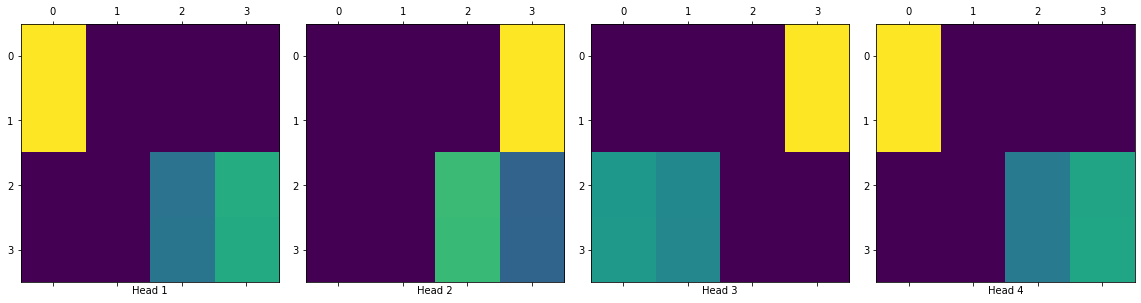

In [18]:
plot_self_attention(b[0], 4)

In [32]:
def collect_q (environment,agent,n):
    q_collection = []
    time_step = environment.current_time_step()
    for x in range(n):
        action_step = agent.policy.action(time_step)
        time_step = environment.step(action_step.action.numpy()[0])
        Q = agent._q_network(time_step.observation)
        q_collection.append(Q[0].numpy().tolist())
    return q_collection

In [35]:
collect_q (tf_env,agent,2)


[[[20.269624710083008, 20.19723892211914]],
 [[19.940690994262695, 20.030078887939453]]]

### Display the videos if needed

In [14]:
embed_mp4(directory + "/bestAgent.mp4")

In [15]:
embed_mp4(directory + "/finalAgent.mp4")